In [1]:
import os
import sys
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm

sys.path.insert(0,'..')
from src.stochastic_process import wienerprocess
from src.sde_solver import eulerMaruyama, milstein

In [2]:
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# Goal of this notebook

The goal of this notebook is to confirm theoretical convergence rates for the numerical methods. The **Euler-Maruyama method has a strong order of convergence of $1/2$**, while the **Milstein method improves this to order $1$**. Further, according to theory **both of the methods have a weak order of $1$**.

# The Milstein method

In addition to the Euler-Maruyama method presented in the introductory notebook, there is also the Milstein method, which has a higher *strong* order of convergence. Let's fixate on the Black Scholes model with the underlying geometric Brownian SDE

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

again. Then, the procedure of the Milstein process is given by

$$
S_{n+1} = S_n + \tau \mu S_n + \sigma S_n \Delta W_n + \frac{\sigma ^ 2}{2} \left(((\Delta W_n) ^2- \tau \right),
$$

where $\tau = T / N$ denotes the step size and $\Delta W_n = W_{n+1} - W_n$ the Wiener increments.

**Vectorization**

Again, since the Black-Scholes model is somewhat easy, it makes sense to use vectorized forms of the SDE solvers. For Euler-Maruyama this can be achieved by
$$
S_{n+1} = S_0 \prod_{k=0}^{n-1} \, \left(1 + \tau \mu + \sigma \Delta W_k\right),
$$
and for the Milstein method by
$$
S_{n+1} = S_0 \prod_{k=0}^{n-1} \, \left(1 + \tau \mu + \sigma \Delta W_k + \frac{\sigma^2}{2} (\Delta W_k^2 - \tau)\right).
$$

# Measuring convergence

It is important to understand that, at each time level $t_n$, both $X_n$ and $X(t_n)$ are random variables. Therefore, in what sense does

$$
|X_n - X(t_n)| \rightarrow 0 \,\, \text{as} \,\, \tau \rightarrow 0?
$$

# Confirming the strong order of convergence

Strong convergence can be seen as path-wise convergence, or the mean of the errors. A numerical scheme is said to be **strongly convergent with order $\gamma$** if

$$
\max_{n=0,\ldots,N} \, \mathbb{E} \, [|X(t_n)-X_n|] \in \mathcal{O}(\tau^{\gamma}).
$$

In [3]:
T = 10
N = 2 ** 12
n_paths = 10 ** 4
W = wienerprocess(T, N, n_paths)
t = np.linspace(0, T, N + 1)

In [4]:
s0 = 1
mu = 0.3
sigma = 0.4
a = mu - sigma ** 2 / 2

In [5]:
# Exact solution for all Wiener paths
ex_sols = s0 * np.exp((a * t.reshape(-1, 1) + sigma * W))

We use $N=2^k$ time steps for $k=4,\ldots,12$ to vary the step size $\tau = T/N$.

In [6]:
N_arr = np.array([2 ** k for k in range(4, 12 + 1)])
errors_EM, errors_MIL = [], []

for i in tqdm(range(len(N_arr))):
    t_eval = np.arange(0, N + 1, int(N / N_arr[i]))
    num_sols = np.zeros((2, N_arr[i] + 1, n_paths))

    num_sols[0] = eulerMaruyama(mu, sigma, s0, N_arr[i], T, W[t_eval], endpoint=False)
    num_sols[1] = milstein(mu, sigma, s0, N_arr[i], T, W[t_eval], endpoint=False)
    
    diff = np.abs(num_sols - ex_sols[t_eval])
    mean_over_paths = np.mean(diff, axis=2)
    
    errors_EM.append(np.max(mean_over_paths[0]))
    errors_MIL.append(np.max(mean_over_paths[1]))

  0%|          | 0/9 [00:00<?, ?it/s]

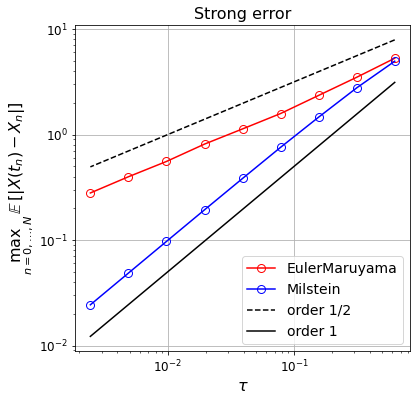

In [7]:
fig = plt.figure(figsize=(6, 6))
plt.loglog(T / N_arr, errors_EM, 'ro-', markersize=8, fillstyle='none', label='EulerMaruyama')
plt.loglog(T / N_arr, errors_MIL, 'bo-', markersize=8, fillstyle='none', label='Milstein')
plt.loglog(T / N_arr, 10 * (T / N_arr) ** 0.5, 'k--', label='order 1/2')
plt.loglog(T / N_arr, 5 * (T / N_arr) ** 1.0, 'k', label='order 1')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\max_{n=0,\ldots,N} \, \mathbb{E} \, [|X(t_n)-X_n|]$')
plt.title('Strong error', size=16)
plt.grid()
plt.legend();

As we can see, the measured errors align almost perfectly with the theorical orders of $1/2$ for Euler-Maruyama and $1$ for the Milstein method.

# Confirming the weak order of convergence

Weak convergence, on the other hand, can be regarded as an error of the mean. A numerical scheme is said to be **strongly convergent with order $\gamma$** if

$$
\max_{n=0,\ldots,N} \,\, | \mathbb{E}\, [X(t_n)] - \mathbb{E} \, [X_n]| \in \mathcal{O}(\tau^{\gamma}).
$$

**Note**: In the following we use a chunk size of $10^3$ samples and for-loops to avoid memory issues.

In [8]:
T = 10
n_paths = 500_000
chunk_size = 10 ** 3

if n_paths > chunk_size:
    n_iters, rem, n_paths = n_paths // chunk_size, n_paths % chunk_size, chunk_size
    if rem > 0: n_iters += 1

We use $N=2^k$ time steps for $k=4,\ldots,10$ and $m=500.000$ samples each. 

In [9]:
N_arr = np.array([2**k for k in range(4, 10+1)])
errors_EM, errors_MIL = [], []

for i in tqdm(range(len(N_arr))):
    t = np.linspace(0, T, N_arr[i] + 1)
    num_sols = np.zeros((2, N_arr[i] + 1, n_paths))

    sum_over_paths = 0    
    for _ in range(n_iters):
        num_sols[0] = eulerMaruyama(mu, sigma, s0, N_arr[i], T, n_paths, endpoint=False)
        num_sols[1] = milstein(mu, sigma, s0, N_arr[i], T, n_paths, endpoint=False)
        sum_over_paths += np.sum(num_sols, axis=-1)
    
    mean_over_paths = sum_over_paths / (n_iters * chunk_size)
    diff = np.abs(s0 * np.exp(mu * t) - mean_over_paths)
    errors_EM.append(np.max(diff[0]))
    errors_MIL.append(np.max(diff[1]))

  0%|          | 0/7 [00:00<?, ?it/s]

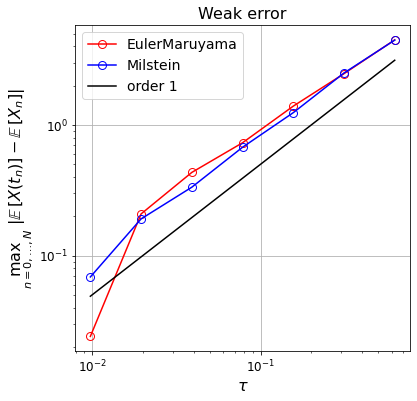

In [10]:
fig = plt.figure(figsize=(6, 6))
plt.loglog(T / N_arr, errors_EM, 'ro-', markersize=8, fillstyle='none', label='EulerMaruyama')
plt.loglog(T / N_arr, errors_MIL, 'bo-', markersize=8, fillstyle='none', label='Milstein')
plt.loglog(T / N_arr, 5 * (T/N_arr)**1.0, 'k', label='order 1')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\max_{n=0,\ldots,N} \,\, | \mathbb{E}\, [X(t_n)] - \mathbb{E} \, [X_n]|$')
plt.title('Weak error', size=16)
plt.grid()
plt.legend();